In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import copy

from altaipony.ffd import FFD

import time
tstamp = time.strftime("%d_%m_%Y_%H_%M", time.localtime())

for att in ['axes.labelsize', 'axes.titlesize', 'legend.fontsize',
            'legend.fontsize', 'xtick.labelsize', 'ytick.labelsize',
            ]:
    plt.rcParams[att] = 13
    
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

paperdir="/home/ekaterina/Documents/002_writing/flares-in-clusters-ii-draft/Flares_in_Clusters_with_K2_2/"

# Load K2 OC flares

In [2]:
df = pd.read_csv("../k2scoc/results/tables/2020_05_final_flares.csv")

hasflares = (df.real==1) & (df.todrop.isnull())
wassearched = (df.real==0)  & (df.todrop.isnull())
Teffs = (df.Teff_median>2500)  & (df.Teff_median < 6000)
df = df[(hasflares  | wassearched) & Teffs]

In [3]:
df.EPIC.unique().shape

(2111,)

# Load K2 rotation studies

## Pleiades

In [4]:
pleiades = pd.read_csv("rebull2016pleiadesrot.tsv",  delimiter='\t',skiprows=68)
pleiadesflares = df[df.cluster=="pleiades"].merge(pleiades[["EPIC","Prot"]], how="left", on="EPIC")
pleiadesflares = pleiadesflares.rename(index=str, columns={"Prot":"prot"})
pleiadesflares[pleiadesflares.real==1].shape


(1583, 26)

## Hyades

In [5]:
hyades = pd.read_csv("rotation/hyades_douglas2019_r.csv", header=None, names=np.arange(33))
hyades = hyades[[3,16,6,17,18,19,20,21,22,26]]
hyades = hyades.rename(index=str, columns={3:"EPIC",6:"3",16:"rotflag",
                                           17:"2",18:"P",19:"H",20:"D",
                                           21:"K",22:"R",26:"mem"})


hyades = hyades.dropna(subset=["EPIC"])
hyades = hyades.dropna(subset=["rotflag"])


hyades.EPIC = hyades.EPIC.apply(lambda x: x.replace(' ',"")[:9]).astype(int)
hyades.rotflag = hyades.rotflag.str.strip(" ")

hyades["prot"] = hyades.apply(lambda x: x[x.rotflag], axis=1)
hyades.head()

hyadesflares = df[df.cluster=="hyades"]
hyadesflares = hyadesflares.merge(hyades, how="left", on="EPIC")


## Praesepe

In [6]:
praesepe = pd.read_csv("rotation/praesepe_douglas2019_r.csv", header=None, names=np.arange(18))
praesepe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,130.815583,20.333611,NaN,212004731.0,3.96,2,3.96,2,1.716940,0.001921,-2.82,4.55,NaN,11.943,0.703,6196.83,6.614383e+17,NYYNN
1,130.089167,19.181694,NaN,211930461.0,14.59,2,14.59,2,-0.000313,0.019007,-11.02,7.48,NaN,13.977,1.754,4019.60,6.612111e+17,YYYNN
2,130.281097,21.915726,2MASS J08410747+2154567,212094548.0,6.60,2,6.60,2,-0.075211,0.090267,NaN,NaN,0.87,18.410,3.251,3097.71,6.651784e+17,NYY-Y
3,129.979355,20.065041,2MASS J08395507+2003542,211988287.0,3.29,2,3.29,2,0.110128,0.001432,-1.14,0.26,NaN,9.991,0.645,6395.48,6.643274e+17,YYYYY
4,130.002548,19.806503,2MASS J08400063+1948235,211971871.0,2.99,K,2.99,K,0.097828,0.002062,NaN,NaN,NaN,10.162,0.676,6289.11,6.613118e+17,YYY-Y


In [7]:
praesepe = praesepe[[3,6]]
praesepe = praesepe.rename(index=str, columns={3:"EPIC",6:"prot"})


praesepe = praesepe.dropna(subset=["EPIC"])
praesepe = praesepe.dropna(subset=["prot"])

praesepe.EPIC = praesepe.EPIC.astype(int)

praesepeflares = df[df.cluster=="praesepe"]
praesepeflares = praesepeflares.merge(praesepe, how="left", on="EPIC")

# Load Raetz+2020 rotation

In [8]:
raetz = pd.read_csv("tables/raetz2020.tsv", delimiter="\t", skiprows=82)
raetz.columns

Index(['EPIC', 'Campaign', 'Kpmag', 'logL(Kp0)', 'KsMAG', 'e_KsMAG', 'Rs',
       'e_Rs', 'Ms', 'e_Ms', 'Teff', 'e_Teff', 'd', 'e_d', 'SpType', 'Prot',
       'Rper', 'logE(Fmax)', 'Sph', 'Sflat(SC)', 'Nflares(SC)', 'nu(SC)',
       'Sflat(LC)', 'Nflares(LC)', 'nu(LC)', '_RA', '_DE'],
      dtype='object')

In [9]:
bins_T = pd.cut(raetz["Teff"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500",
                        "3500-3750","3750-4000","4000-5000","5000-6000"])

Traetz = raetz.groupby(bins_T)

In [10]:
for bint, g in Traetz:
    print(bint,g.shape[0])

2500-3000 1
3000-3250 6
3250-3500 22
3500-3750 12
3750-4000 15
4000-5000 0
5000-6000 0


# Rotation histogram in each Teff bin

In [11]:
# Rotation bins:
bins = np.logspace(-1,2,30)

In [12]:
bins_T = pd.cut(hyadesflares["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500",
                        "3500-3750","3750-4000","4000-5000","5000-6000"])

Thyades = hyadesflares.groupby(bins_T)

bins_T = pd.cut(praesepeflares["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500",
                        "3500-3750","3750-4000","4000-5000","5000-6000"])

Tpraesepe = praesepeflares.groupby(bins_T)

bins_T = pd.cut(pleiadesflares["Teff_median"],
                bins=[2500,3000,3250,3500,3750,4000,5000,6000],
                labels=["2500-3000","3000-3250","3250-3500",
                        "3500-3750","3750-4000","4000-5000","5000-6000"])

Tpleiades = pleiadesflares.groupby(bins_T)

NameError: name 'df_pivot' is not defined

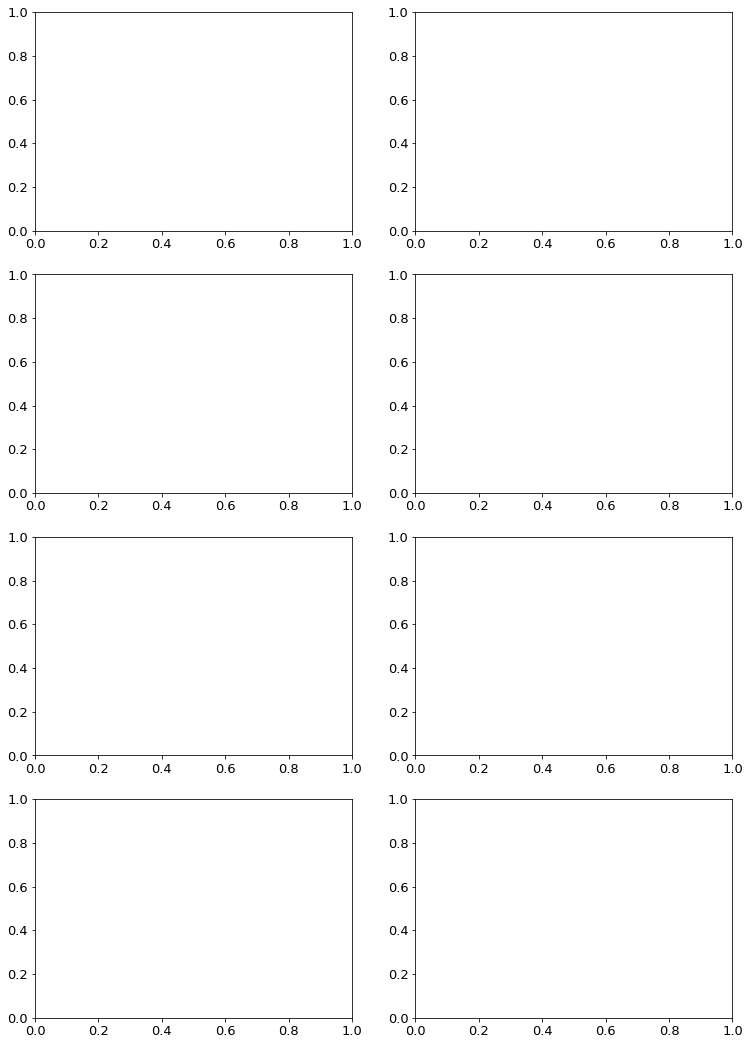

In [13]:
def totn_frac(k, cluster):
    r = df_pivot.loc[bint,('f',   cluster)]
    rstr = fr"${float(r)*100:.0f}\,\%$"
    r = df_totn.loc[bint,('P',   cluster)]
    nstr = f"{int(r)}"
    if k==0:
        lab = fr"{cluster} ({nstr}, {rstr})"
    else: 
        lab = fr"{nstr} ({rstr})"
    return lab

fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5), squeeze=True)
axes = [l for x in axes for l in x]

k=0
for bint, g in Tpleiades:
    g = g.drop_duplicates(subset=["EPIC","prot"])
    lab = totn_frac(k, "Pleiades")
    g.prot.hist(bins=bins, ax=axes[k],edgecolor="maroon", linestyle="dotted",
                histtype="step",linewidth=2.5,label=lab)
  
    k += 1
k=0
for bint, g in Thyades:
    g = g.drop_duplicates(subset=["EPIC","prot"])
    lab = totn_frac(k, "Hyades")
    g.prot.hist(bins=bins, ax=axes[k],edgecolor="orangered",
                histtype="step",linewidth=2.5,label=lab)
    k += 1
    
#------------------------------------------------------
# k=0
# for bint, g in Traetz:
#     g = g.drop_duplicates(subset=["EPIC","Prot"])
#     g.Prot.hist(bins=bins, ax=axes[k],edgecolor="k", 
#                 histtype="step",linewidth=2,label="Raetz+2020")
#     k += 1
#------------------------------------------------------   
    
k=0
for bint, g in Tpraesepe:
    g = g.drop_duplicates(subset=["EPIC","prot"])
    print("Praesepe",g.shape)
    lab = totn_frac(k, "Praesepe")
    g.prot.hist(bins=bins, ax=axes[k],edgecolor="orange",
                histtype="step",linewidth=2.5, linestyle="dashed",
                label=lab)
    
    axes[k].set_title(bint + " K")
    axes[k].set_xscale("log")
    axes[k].set_xlim(.1,100)
    axes[k].set_xlabel(r"$P_\mathrm{rot}$ [d]", fontsize=14)
    k += 1
    
  
numer = ["a.","b.","c.","d.","e.","f.","g."]
locs = {0:.5,1:.6,2:.4,3:.15,4:.15,5:.15,6:.15}
for i, ax in enumerate(axes[:-1:]):
    ax.grid(False)
    ax.set_ylabel("number of stars")
    ax.tick_params(axis='x', length=10, which="both")
    start, end = ax.get_ylim()
    print((end-start)//3, end, start)
    ax.yaxis.set_ticks(np.arange(start, end, (end-start)//5))

    ax.text(0.05, 0.9, numer[i], horizontalalignment='left',fontsize=14,
                         verticalalignment='bottom', transform=ax.transAxes)
    ax.legend(frameon=False, fontsize=12, loc=(locs[i],.73))
 
axes[-1].axis('off')
#axes[0].legend()
plt.tight_layout()

# plt.savefig(f"plots/{tstamp}_SpT_wise_rotation.png", dpi=300)
# plt.savefig(f"{paperdir}pics/rotation/SpT_wise_rotation.png", dpi=300)

# Histogram of individuall Teffs in the bins

NameError: name 'r' is not defined

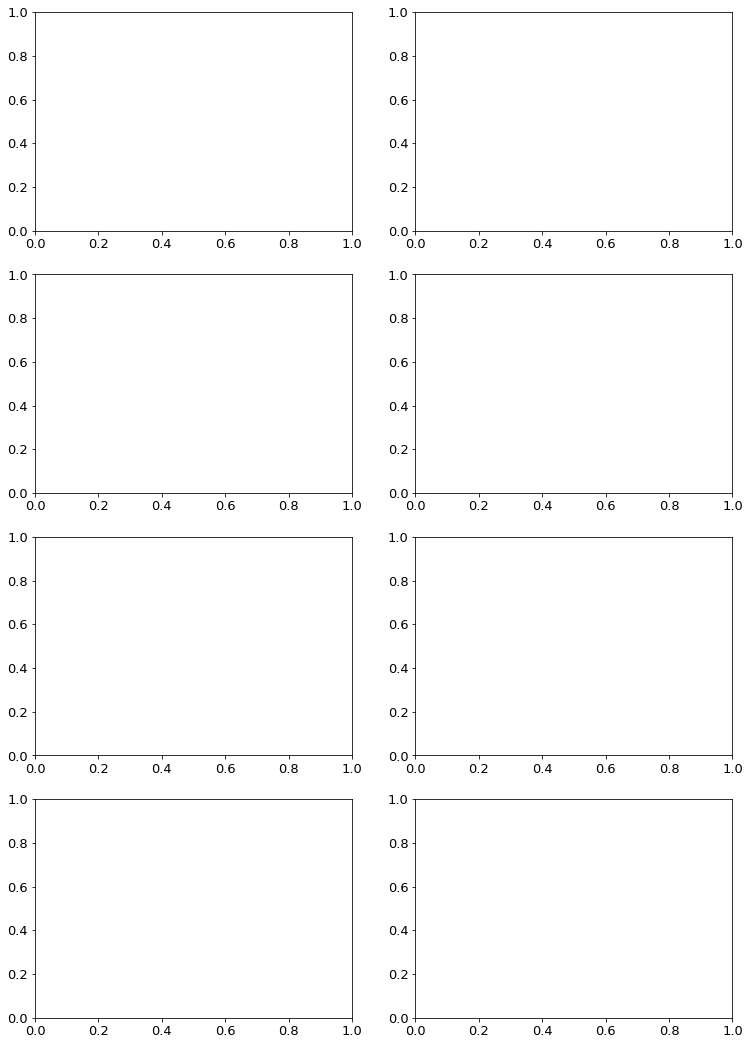

In [14]:
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(12.5,18.5), squeeze=True)
axes = [l for x in axes for l in x]
k=0
for bint, g in Tpleiades:
    g = g.drop_duplicates(subset=["EPIC"])
    bins = np.linspace(float(bint.split("-")[0]),float(bint.split("-")[1]),10)

    g.Teff_median.hist(bins=bins, ax=axes[k],edgecolor="maroon", linestyle="dotted",
                histtype="step",linewidth=2,label=f"Pleiades ({r})" )#,density=True)
    
    k += 1
k=0
for bint, g in Thyades:
    g = g.drop_duplicates(subset=["EPIC"])
    bins = np.linspace(float(bint.split("-")[0]),float(bint.split("-")[1]),10)
    g.Teff_median.hist(bins=bins, ax=axes[k],edgecolor="orangered",
                histtype="step",linewidth=2,label="Hyades")#,density=True)
    k += 1
k=0
for bint, g in Tpraesepe:
    g = g.drop_duplicates(subset=["EPIC"])
    bins = np.linspace(float(bint.split("-")[0]),float(bint.split("-")[1]),10)
    g.Teff_median.hist(bins=bins, ax=axes[k],edgecolor="orange",
                histtype="step",linewidth=2, linestyle="dashed",
                label="Praesepe")#,density=True)
    
    axes[k].set_title(bint + " K")
    #axes[k].set_xscale("log")
    #axes[k].set_xlim(.1,100)
    axes[k].set_xlabel(r"$T_\mathrm{eff}$ [K]")
    k += 1
axes[-1].axis('off')
axes[0].legend(loc=2)
plt.tight_layout()
plt.savefig(f"plots/{tstamp}_Teff_count_histogram_binwise.png", dpi=300)

In [13]:
#hyadesflares[(hyadesflares.Teff_median>3500) & (hyadesflares.Teff_median< 3750)].sort_values("prot")[["prot","EPIC","ed_rec"]].drop_duplicates(subset=["EPIC","prot"])

# Fraction of stars with rotation periods in all bins

In [15]:
rotfrac = {}
for cluster, d,binned in [("Praesepe",praesepeflares,Tpraesepe),
                          ("Hyades",hyadesflares, Thyades),
                          ("Pleiades",pleiadesflares,Tpleiades)]:
    d = d.drop_duplicates(subset=["EPIC","prot"])
    print(cluster,
          d[d.prot.isnull()].shape[0], d[~d.prot.isnull()].shape[0],
          d[d.prot.isnull()].shape[0] + d[~d.prot.isnull()].shape[0], d.shape[0])
    rotfrac[cluster] = {}
    for tbin, g in binned:
        g = g.drop_duplicates(subset=["EPIC","prot"])
        rotfrac[cluster][tbin] = {"cluster":cluster,
                                    "n_s":g.shape[0],
                                  "P":g[~g.prot.isnull()].shape[0],
                                  "f":g[~g.prot.isnull()].shape[0]/g.shape[0],
                                  
                                  } 
        print(tbin, g[g.prot.isnull()].shape[0],g[~g.prot.isnull()].shape[0],)

Praesepe 333 580 913 913
2500-3000 7 6
3000-3250 131 197
3250-3500 98 152
3500-3750 26 52
3750-4000 11 31
4000-5000 26 67
5000-6000 34 75
Hyades 42 128 170 170
2500-3000 8 8
3000-3250 13 41
3250-3500 10 34
3500-3750 5 11
3750-4000 0 3
4000-5000 6 24
5000-6000 0 7
Pleiades 152 589 741 741
2500-3000 23 29
3000-3250 45 273
3250-3500 41 128
3500-3750 12 26
3750-4000 7 18
4000-5000 10 54
5000-6000 14 61


In [16]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in rotfrac.items() for innerKey, values in innerDict.items()}

rotf = pd.DataFrame(reform).T


In [17]:
rotf

cluster  n_s    P         f
Praesepe 2500-3000  Praesepe   13    6  0.461538
         3000-3250  Praesepe  328  197   0.60061
         3250-3500  Praesepe  250  152     0.608
         3500-3750  Praesepe   78   52  0.666667
         3750-4000  Praesepe   42   31  0.738095
         4000-5000  Praesepe   93   67   0.72043
         5000-6000  Praesepe  109   75  0.688073
Hyades   2500-3000    Hyades   16    8       0.5
         3000-3250    Hyades   54   41  0.759259
         3250-3500    Hyades   44   34  0.772727
         3500-3750    Hyades   16   11    0.6875
         3750-4000    Hyades    3    3         1
         4000-5000    Hyades   30   24       0.8
         5000-6000    Hyades    7    7         1
Pleiades 2500-3000  Pleiades   52   29  0.557692
         3000-3250  Pleiades  318  273  0.858491
         3250-3500  Pleiades  169  128  0.757396
         3500-3750  Pleiades   38   26  0.684211
         3750-4000  Pleiades   25   18      0.72
         4000-5000  Pleiades   64   54   0.84375
         5000-6000  Pleiades   75   61  0.813333

In [18]:
df_pivot = rotf.reset_index()
df_pivot = df_pivot.rename(index=str, columns={"level_1":r"$T_\mathrm{eff}$ [K]"})
df_pivot = df_pivot.pivot(index=r"$T_\mathrm{eff}$ [K]", columns='cluster', values=["f"])
#df_pivot = df_pivot.rename(index=str, columns={"n_s":r"$n_s$", "P": r"$n_P$"})
df_pivot = df_pivot.applymap(lambda x: f"{x:.2f}" )
df_pivot

f                  
cluster              Hyades Pleiades Praesepe
$T_\mathrm{eff}$ [K]                         
2500-3000              0.50     0.56     0.46
3000-3250              0.76     0.86     0.60
3250-3500              0.77     0.76     0.61
3500-3750              0.69     0.68     0.67
3750-4000              1.00     0.72     0.74
4000-5000              0.80     0.84     0.72
5000-6000              1.00     0.81     0.69

In [19]:

df_totn = rotf.reset_index()
df_totn = df_totn.rename(index=str, columns={"level_1":r"$T_\mathrm{eff}$ [K]"})
df_totn = df_totn.pivot(index=r"$T_\mathrm{eff}$ [K]", columns='cluster', values=["P"])
#df_totn = df_totn.rename(index=str, columns={"n_s":r"$n_s$", "P": r"$n_P$"})
df_totn = df_totn.applymap(lambda x: f"{x:.0f}" )
df_totn

P                  
cluster              Hyades Pleiades Praesepe
$T_\mathrm{eff}$ [K]                         
2500-3000                 8       29        6
3000-3250                41      273      197
3250-3500                34      128      152
3500-3750                11       26       52
3750-4000                 3       18       31
4000-5000                24       54       67
5000-6000                 7       61       75

In [20]:
df_pivot.columns

MultiIndex([('f',   'Hyades'),
            ('f', 'Pleiades'),
            ('f', 'Praesepe')],
           names=[None, 'cluster'])

In [19]:
arr = np.array(df_pivot).astype(float).flatten()
np.median(arr), np.min(arr), np.max(arr)

with open(f"{paperdir}values/median_stars_with_rotation_periods.txt", "w") as f:
    f.write(str(int(np.rint(np.median(arr)*100))))
with open(f"{paperdir}values/min_stars_with_rotation_periods.txt", "w") as f:
    f.write(str(int(np.rint(np.min(arr)*100))))
with open(f"{paperdir}values/max_stars_with_rotation_periods.txt", "w") as f:
    f.write(str(int(np.rint(np.max(arr)*100))))

In [20]:

nc = 'c' * (df_pivot.shape[1])
stri = df_pivot.to_latex(index=True,escape=False, column_format=f"l{nc}r")
stri = stri.replace("\\toprule","\hline")
stri = stri.replace("\\midrule","\hline")
stri = stri.replace("{}","")
stri = stri.replace(r" & \multicolumn{3}{l}{f} \\","")

stri = stri.replace("\\bottomrule","\hline\n" )
with open(f"{paperdir}tables/searched_with_rotation.tex", "w") as f:
    f.write(stri)

In [21]:
print(stri)

\begin{tabular}{lcccr}
\hline

cluster & Hyades & Pleiades & Praesepe \\
$T_\mathrm{eff}$ [K] &        &          &          \\
\hline
2500-3000            &   0.57 &     0.61 &     0.51 \\
3000-3250            &   0.84 &     0.88 &     0.68 \\
3250-3500            &   0.84 &     0.90 &     0.75 \\
3500-3750            &   0.69 &     0.86 &     0.68 \\
3750-4000            &   1.00 &     0.82 &     0.78 \\
4000-5000            &   0.58 &     0.85 &     0.80 \\
5000-6000            &   1.00 &     0.86 &     0.68 \\
\hline

\end{tabular}



# Median Prot and standard dev.

In [22]:
rotfrac = {}
for cluster, d,binned in [("Praesepe",praesepeflares,Tpraesepe),
                          ("Hyades",hyadesflares, Thyades),
                          ("Pleiades",pleiadesflares,Tpleiades)]:
    d = d.drop_duplicates(subset=["EPIC","prot"])
    print(cluster,
          d[d.prot.isnull()].shape[0], d[~d.prot.isnull()].shape[0],
          d[d.prot.isnull()].shape[0] + d[~d.prot.isnull()].shape[0], d.shape[0])
    rotfrac[cluster] = {}
    for tbin, g in binned:
        g = g.drop_duplicates(subset=["EPIC","prot"])
        rotfrac[cluster][tbin] = {"cluster":cluster,
                                    "n_s":g.shape[0],
                                  "P":g[~g.prot.isnull()].shape[0],
                                  "f":g[~g.prot.isnull()].shape[0]/g.shape[0],
                                  "Pmedian":g.prot.median(),
                                  "P50th":g.prot.quantile(q=0.5),
                                  "Pstd":g.prot.std(),
                                  "P_up_bound":g.prot.max() - g.prot.median(),
                                  "P_low_bound":g.prot.median() - g.prot.min(),
                                  "P5th":g.prot.quantile(q=0.5)-g.prot.quantile(q=0.05),
                                  "P95th":g.prot.quantile(q=0.95)-g.prot.quantile(q=0.5),
                                  } 
        print(tbin, g[g.prot.isnull()].shape[0],g[~g.prot.isnull()].shape[0],)

Praesepe 333 580 913 913
2500-3000 7 6
3000-3250 131 197
3250-3500 98 152
3500-3750 26 52
3750-4000 11 31
4000-5000 26 67
5000-6000 34 75
Hyades 42 128 170 170
2500-3000 8 8
3000-3250 13 41
3250-3500 10 34
3500-3750 5 11
3750-4000 0 3
4000-5000 6 24
5000-6000 0 7
Pleiades 152 589 741 741
2500-3000 23 29
3000-3250 45 273
3250-3500 41 128
3500-3750 12 26
3750-4000 7 18
4000-5000 10 54
5000-6000 14 61


In [23]:
reform = {(outerKey, innerKey): values for outerKey, innerDict in rotfrac.items() for innerKey, values in innerDict.items()}

rotf = pd.DataFrame(reform).T
rotf

cluster  n_s    P         f  Pmedian    P50th      Pstd  \
Praesepe 2500-3000  Praesepe   13    6  0.461538    0.265    0.265    0.1772   
         3000-3250  Praesepe  328  197   0.60061     1.09     1.09   4.76502   
         3250-3500  Praesepe  250  152     0.608    8.225    8.225    9.1822   
         3500-3750  Praesepe   78   52  0.666667    18.16    18.16   5.43531   
         3750-4000  Praesepe   42   31  0.738095    15.33    15.33   1.61263   
         4000-5000  Praesepe   93   67   0.72043    12.42    12.42   2.70746   
         5000-6000  Praesepe  109   75  0.688073     8.89     8.89   3.18587   
Hyades   2500-3000    Hyades   16    8       0.5    0.355    0.355  0.252866   
         3000-3250    Hyades   54   41  0.759259     1.44     1.44    4.8884   
         3250-3500    Hyades   44   34  0.772727      7.3      7.3   10.2889   
         3500-3750    Hyades   16   11    0.6875    10.97    10.97   8.95907   
         3750-4000    Hyades    3    3         1    15.18    15.18   5.03807   
         4000-5000    Hyades   30   24       0.8    11.95    11.95   8.56821   
         5000-6000    Hyades    7    7         1     9.39     9.39  0.458091   
Pleiades 2500-3000  Pleiades   52   29  0.557692   0.3443   0.3443   0.49522   
         3000-3250  Pleiades  318  273  0.858491      0.5      0.5  0.563818   
         3250-3500  Pleiades  169  128  0.757396   1.0805   1.0805   1.73082   
         3500-3750  Pleiades   38   26  0.684211  2.26495  2.26495   4.32418   
         3750-4000  Pleiades   25   18      0.72  3.23265  3.23265   2.09493   
         4000-5000  Pleiades   64   54   0.84375    4.811    4.811   3.31494   
         5000-6000  Pleiades   75   61  0.813333   4.0255   4.0255   2.01334   

                   P_up_bound P_low_bound      P5th    P95th  
Praesepe 2500-3000      0.375       0.135    0.1175     0.29  
         3000-3250      33.08        0.91     0.814   12.468  
         3250-3500     29.845       7.715    7.3195   17.354  
         3500-3750       9.42       16.35   14.9025   4.5585  
         3750-4000       3.22        6.13     1.975     1.75  
         4000-5000      12.02        9.99     2.293    4.804  
         5000-6000      18.95         8.7     3.355    3.375  
Hyades   2500-3000      0.545       0.155    0.1515    0.461  
         3000-3250      26.66        1.18      1.11     8.13  
         3250-3500      31.26        6.41     6.281  20.8465  
         3500-3750      10.97       10.39      9.91   10.735  
         3750-4000       0.51        8.46     7.614    0.459  
         4000-5000      37.37       10.49    9.4375   2.9565  
         5000-6000       0.43        1.01     0.785    0.349  
Pleiades 2500-3000     2.2295      0.2518   0.16714  0.84034  
         3000-3250     5.3529      0.4176   0.27474  1.15588  
         3250-3500    12.6181      0.8243  0.753235  3.35054  
         3500-3750    15.0177     1.95465   1.91927  10.8183  
         3750-4000    4.55065     2.93035   2.84875  3.83792  
         4000-5000     6.1953      4.5757   4.45087  4.43147  
         5000-6000     4.4594      3.3358    3.0056   3.1542

In [24]:
rotf.reset_index().rename(index=str, columns={"level_1":"Tmedian"}).drop("level_0",axis=1).to_csv("tables/rotation_median_std.csv", index=False)